# **Clasificación utilizando XGBoost (Core)**

**Objetivo:** Implementar un pipeline completo de machine learning para un problema de clasificación utilizando XGBoost. Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

**Dataset: Heart Disease UCI**

** Descripción del Dataset:** El dataset de enfermedades del corazón de la UCI contiene información sobre varios factores de riesgo asociados con enfermedades cardíacas. El objetivo es predecir la presencia de enfermedad cardíaca basándose en estos factores.



Column Descriptions:

id (Unique id for each patient)

age (Age of the patient in years)

origin (place of study)

sex (Male/Female)
cp chest pain type

typical angina,

atypical angina,

non-anginal,

asymptomatic

trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))

chol (serum cholesterol in mg/dl)

fbs (if fasting blood sugar > 120 mg/dl)

restecg (resting electrocardiographic results)

Values: [normal, stt abnormality, lv hypertrophy]

thalach: maximum heart rate achieved

exang: exercise-induced angina (True/ False)

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by fluoroscopy

thal: [normal; fixed defect; reversible defect]

num: the predicted attribute

In [81]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [74]:
path = 'C:/Users/damav/Desktop/Codingdojo/clases/machine-learning/data/heart.csv'

df = pd.read_csv(path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**1. Exploración Inicial:**

* **Revisar la estructura del dataset.**

* **Describir las variables y su distribución.**

* **Identificar y documentar valores faltantes y outliers.**


In [ ]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")


Número de registros duplicados: 1


In [ ]:
df_copy = df.copy()

# Step 2: Drop duplicates from the copy
df_copy.drop_duplicates(inplace=True)

In [ ]:
# Información del dataset, no hay necesidad de convertir los datos. 
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [ ]:
# Verificamos los valores faltantes
qsna=df_copy.shape[0]-df.isnull().sum(axis=0)
qna=df_copy.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
age,302,0,0.0
sex,302,0,0.0
cp,302,0,0.0
trestbps,302,0,0.0
chol,302,0,0.0
fbs,302,0,0.0
restecg,302,0,0.0
thalach,302,0,0.0
exang,302,0,0.0
oldpeak,302,0,0.0


In [ ]:
# Convertir los datos
df['sex'] = df['sex'].astype('category')
df['cp'] = df['cp'].astype('category')
df['fbs'] = df['fbs'].astype('bool')
df['restecg'] = df['restecg'].astype('category')
df['exang'] = df['exang'].astype('bool')
df['slope'] = df['slope'].astype('category')
df['thal'] = df['thal'].astype('category')
df['target'] = df['target'].astype('bool') 

# Check the changes
print(df.dtypes)

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs             bool
restecg     category
thalach        int64
exang           bool
oldpeak      float64
slope       category
ca             int64
thal        category
target          bool
dtype: object


In [ ]:
# Estadísticas descriptivas
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
descriptive_stats = df_copy[numerical_vars].describe()

print(descriptive_stats)

# Alta STD para Trsdtbps, Chol, Thalach

             age    trestbps        chol     thalach     oldpeak          ca
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000
mean    54.42053  131.602649  246.500000  149.569536    1.043046    0.718543
std      9.04797   17.563394   51.753489   22.903527    1.161452    1.006748
min     29.00000   94.000000  126.000000   71.000000    0.000000    0.000000
25%     48.00000  120.000000  211.000000  133.250000    0.000000    0.000000
50%     55.50000  130.000000  240.500000  152.500000    0.800000    0.000000
75%     61.00000  140.000000  274.750000  166.000000    1.600000    1.000000
max     77.00000  200.000000  564.000000  202.000000    6.200000    4.000000


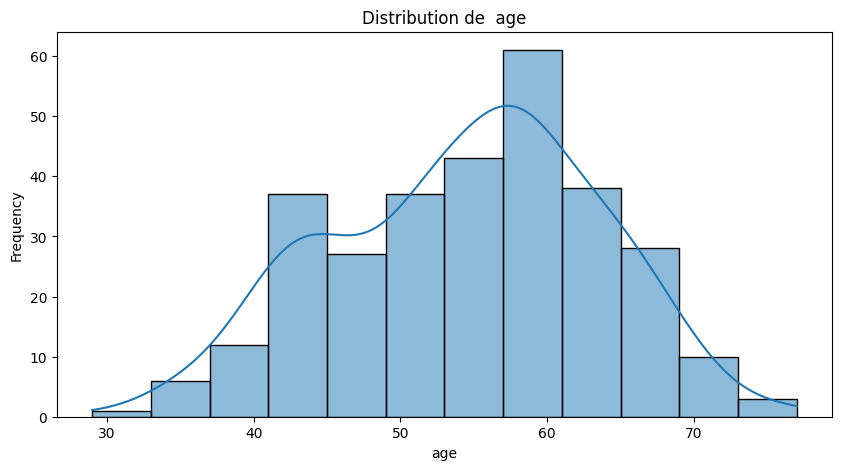

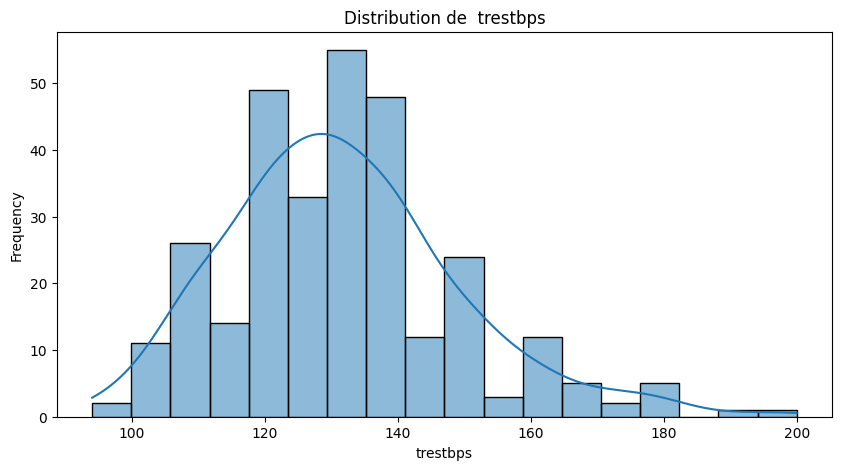

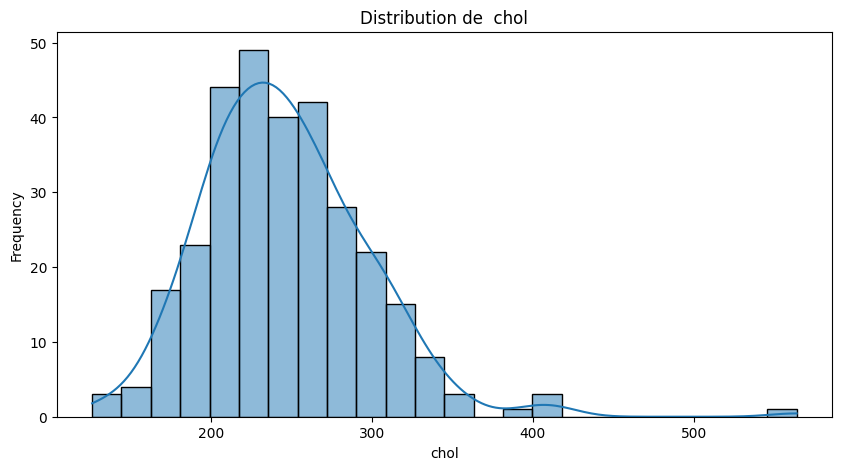

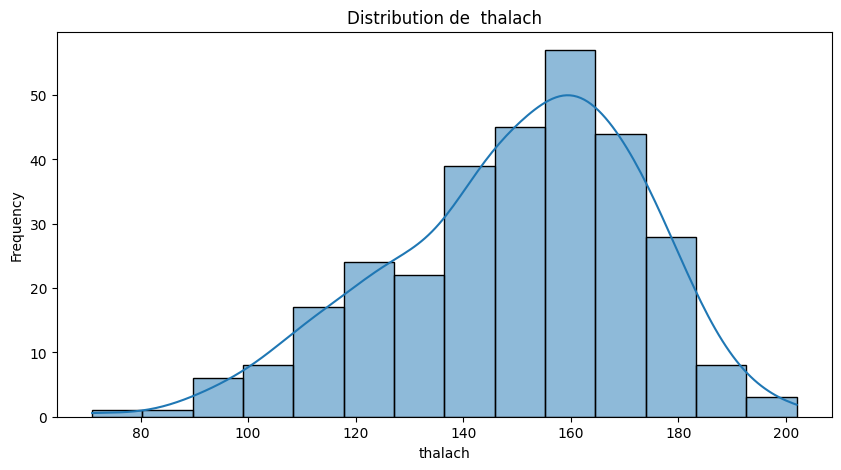

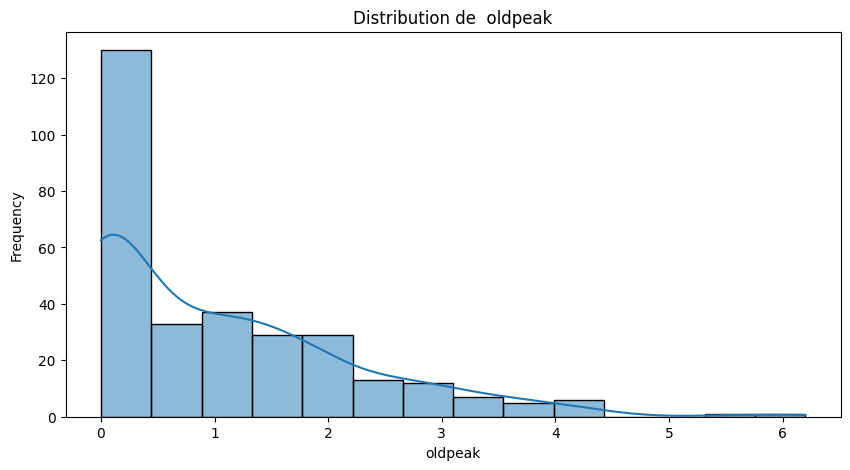

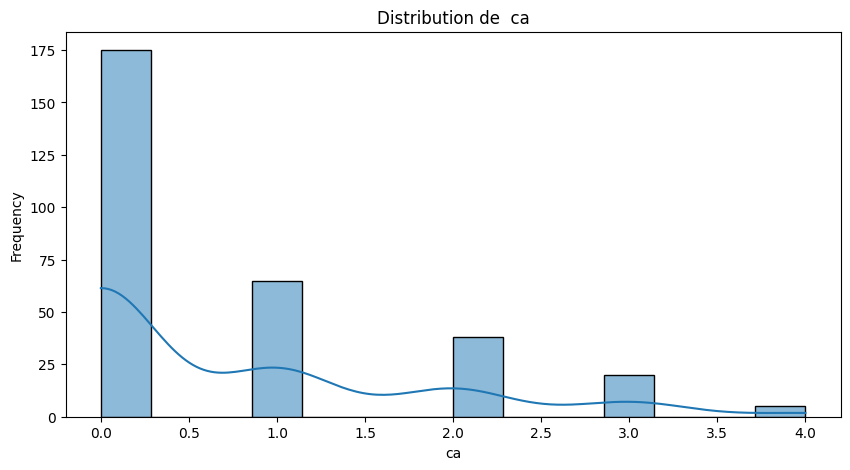

In [67]:
# Visulizacion de valores anomalos y la distribucion de los datos

#Histograma
for var in numerical_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution de  {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

## **Parte 2: Análisis Exploratorio de Datos (EDA)**

**Análisis Estadístico Descriptivo:**

**Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).**

**Analizar la distribución de las variables categóricas.**

In [68]:
# Analis descritivo y distrinuciones de datos categoricos
# Distribution of categorical variables
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']


for var in categorical_vars:
    print(f'Distribution of {var}:')
    print(df_copy[var].value_counts(normalize=True) * 100) 
    print('\n')


Distribution of sex:
sex
1    68.211921
0    31.788079
Name: proportion, dtype: float64


Distribution of cp:
cp
0    47.350993
2    28.476821
1    16.556291
3     7.615894
Name: proportion, dtype: float64


Distribution of fbs:
fbs
0    85.099338
1    14.900662
Name: proportion, dtype: float64


Distribution of restecg:
restecg
1    50.000000
0    48.675497
2     1.324503
Name: proportion, dtype: float64


Distribution of exang:
exang
0    67.218543
1    32.781457
Name: proportion, dtype: float64


Distribution of slope:
slope
2    46.688742
1    46.357616
0     6.953642
Name: proportion, dtype: float64


Distribution of ca:
ca
0    57.947020
1    21.523179
2    12.582781
3     6.622517
4     1.324503
Name: proportion, dtype: float64


Distribution of thal:
thal
2    54.635762
3    38.741722
1     5.960265
0     0.662252
Name: proportion, dtype: float64


Distribution of target:
target
1    54.304636
0    45.695364
Name: proportion, dtype: float64




**2. Visualizaciones:**

* Crear histogramas y gráficos de barras para entender la distribución de las variables.

* Crear un mapa de calor para visualizar las correlaciones entre las variables.

* Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.



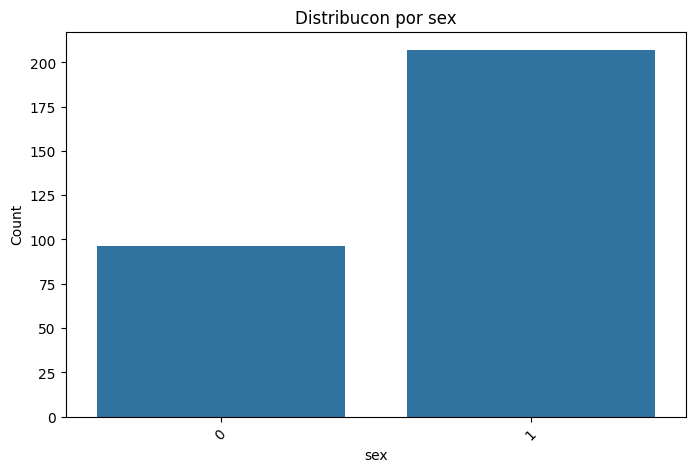

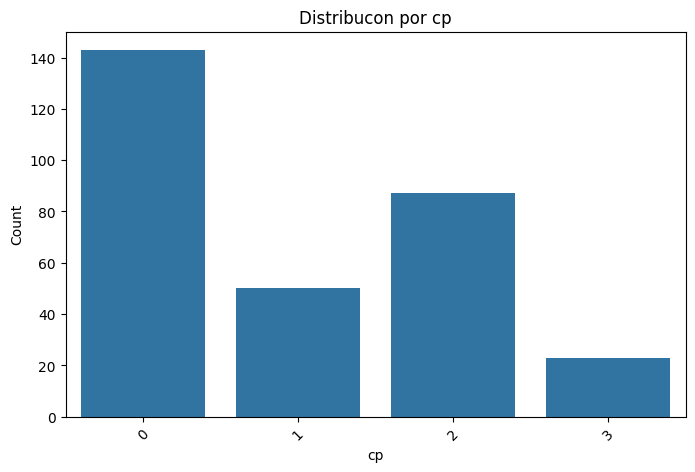

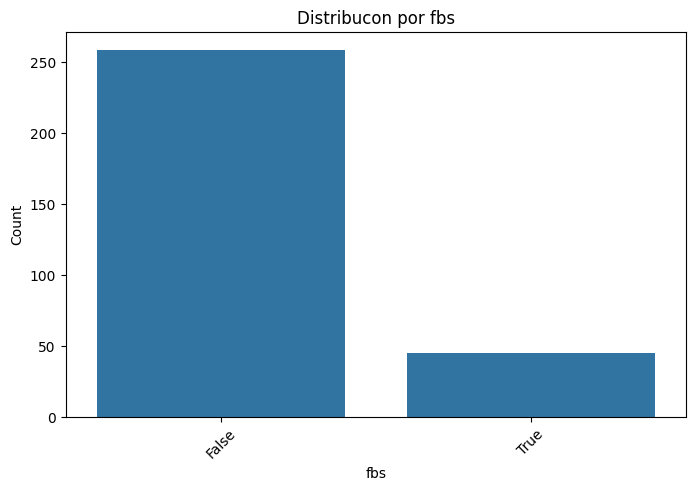

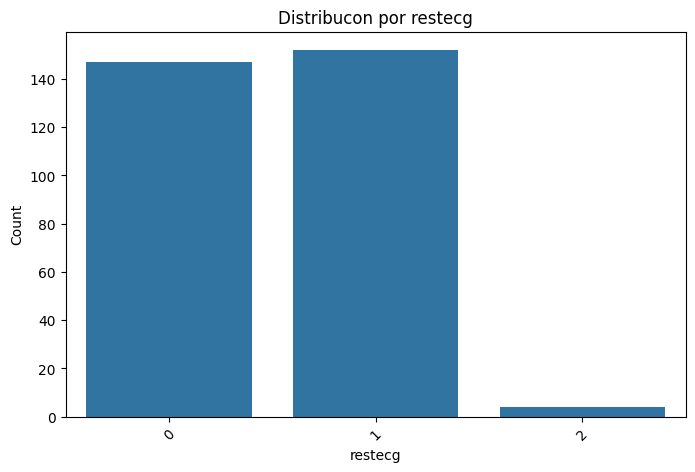

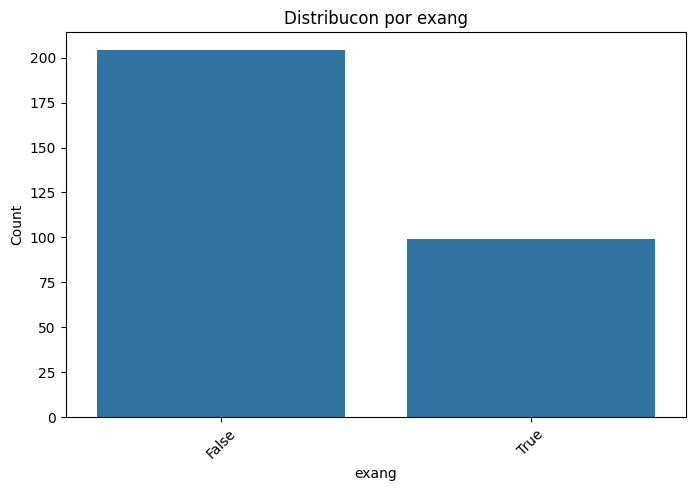

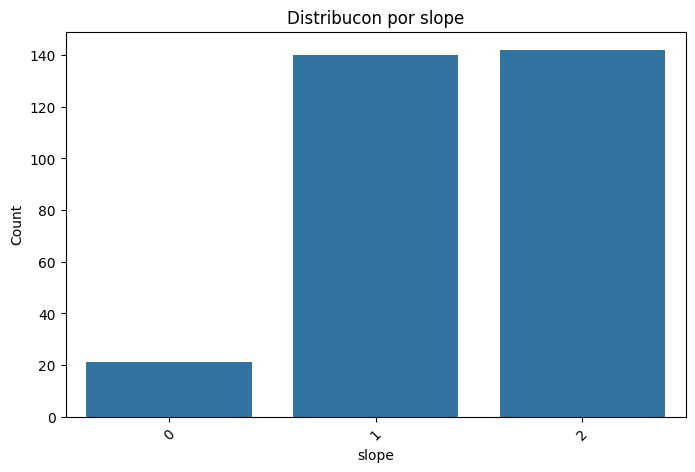

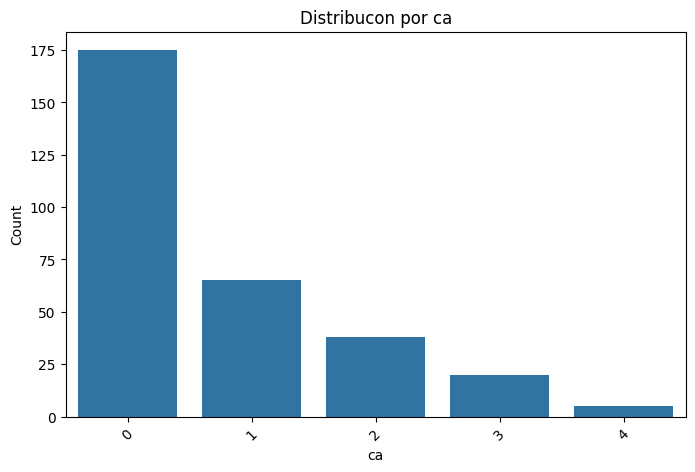

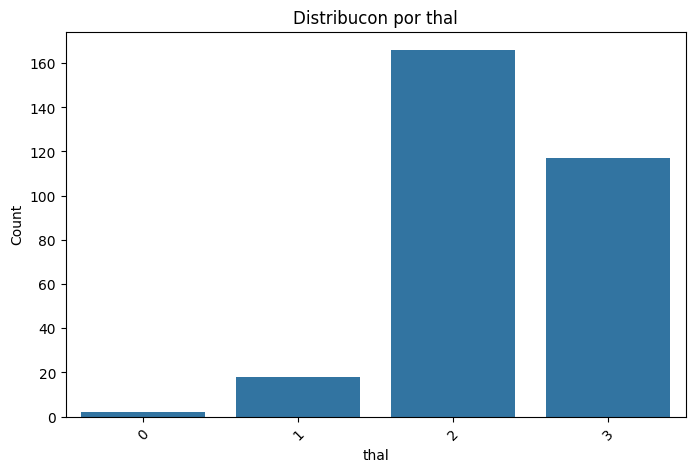

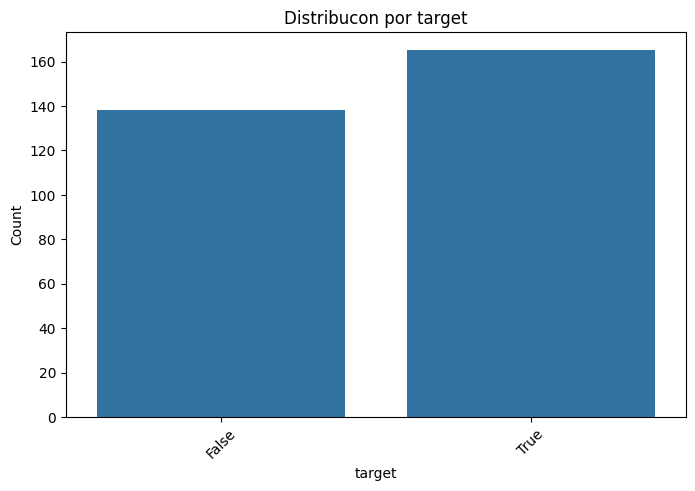

In [69]:
# Bar plots for categorical variables. Histograma mas arriba, en la seccion de valores anomalos.
for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=var)
    plt.title(f'Distribucon por {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

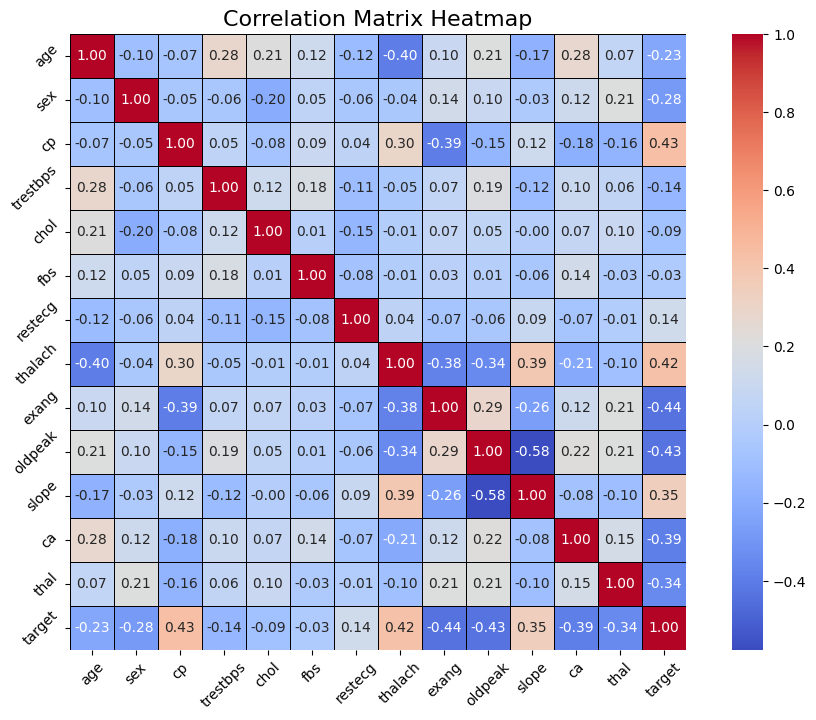

In [70]:
# Matriz de Correlación
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))

# Mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar=True, linewidths=.5, linecolor='black', 
            mask=None) 
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

**3. Valores Faltantes y Outliers:**

* Detectar y tratar valores faltantes.

* Identificar y manejar outliers.


No detectamos valores nulos, y en base a nuestro graficos, no tenemos mayor necesidad de limpiar los datos par eliminar Outliers.

## **Parte 3: Preprocesamiento de Datos**

**1. Transformación de Columnas:**

* Codificar variables categóricas utilizando One-Hot Encoding.

* Escalar características numéricas utilizando StandardScaler.

**2. División del Conjunto de Datos:**

* Dividir el dataset en conjuntos de entrenamiento y prueba.

In [71]:
df = df_copy

# Convertir los datos
for col in ['sex', 'cp', 'restecg', 'slope', 'thal']:
    df[col] = df[col].astype('category')

# One Hot Encoding para las variables categoricas
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Escalar las variables numéricas
numerical_cols = ['age', 'trestbps', 'chol', 'oldpeak', 'thalach', 'ca']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Definir las variables x e y
X = df_encoded.drop('target', axis=1)  # Features
y = df_encoded['target']  # Target variable

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vemos los resultados


## **Parte 4: Implementación de XGBoost**

**1. Entrenamiento del Modelo:**

* Entrenar un modelo de XGBoost con hiperparámetros básicos.

* Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.

**2. Optimización de Hiperparámetros:**

* Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de XGBoost.

**3Evaluación del Modelo Optimizado:**

* Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

In [76]:
# Step 4: Train the XGBoost Model
model = xgb.XGBClassifier( eval_metric='logloss')
model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  


In [79]:
# Step 6: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Model Evaluation Metrics:
Accuracy: 0.82
Precision: 0.86
Recall: 0.78
F1 Score: 0.82
ROC AUC: 0.90


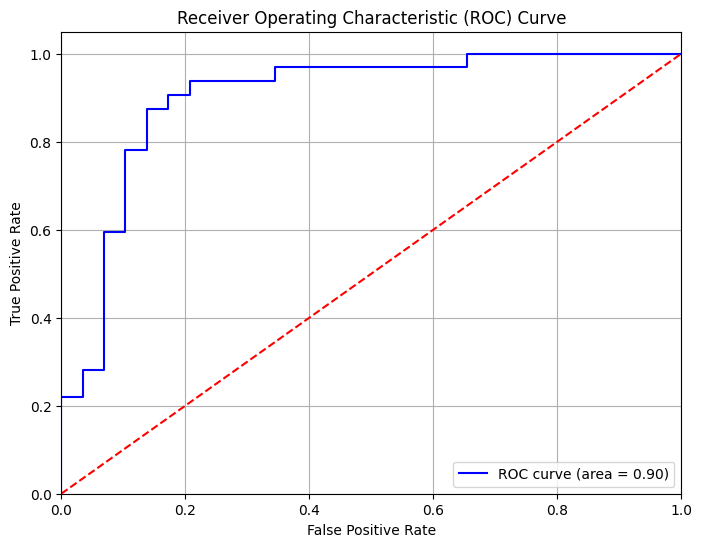

In [80]:
# Step 7: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [93]:
#  Optimizacion con GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'),
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=3,         
                            verbose=1,   
                            n_jobs=-1)

grid_search.fit(X_train, y_train)

# Mejor modelo con GridSearchCV
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Prediccion con el modelo optimizado
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [94]:
# Evaluacion del Mejor Modelo
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print("\nOptimized Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_optimized:.2f}")
print(f"Precision: {precision_optimized:.2f}")
print(f"Recall: {recall_optimized:.2f}")
print(f"F1 Score: {f1_optimized:.2f}")
print(f"ROC AUC: {roc_auc_optimized:.2f}")


Optimized Model Evaluation Metrics:
Accuracy: 0.80
Precision: 0.86
Recall: 0.75
F1 Score: 0.80
ROC AUC: 0.90


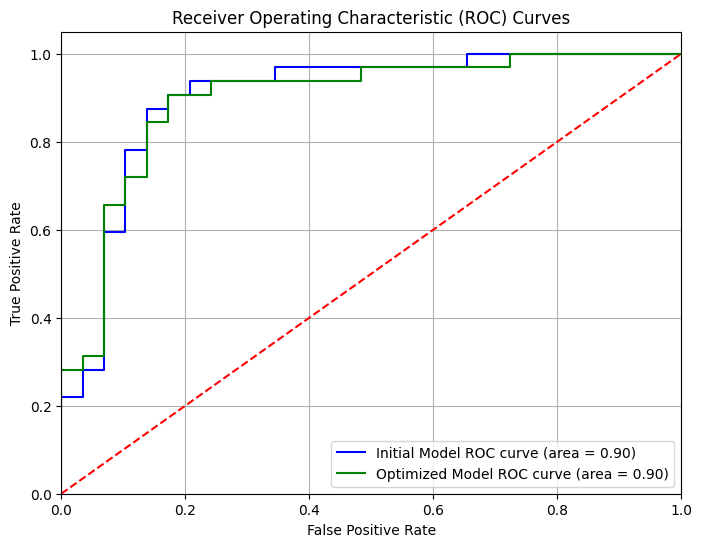

In [ ]:
# Calculamos la curva ROC para el modelo inicial y el modelo optimizado
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_pred_proba)
roc_auc_initial = roc_auc_score(y_test, y_pred_proba)  # Ensure roc_auc_initial is defined

# Calculamos la curva ROC para el modelo optimizado
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)  # Ensure roc_auc_optimized is defined

# Graficamos las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_initial, tpr_initial, color='blue', label='Initial Model ROC curve (area = %0.2f)' % roc_auc_initial)
plt.plot(fpr_optimized, tpr_optimized, color='green', label='Optimized Model ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Aun que ciertos valores son diferentes, no podemos observar que vamos modelos se desempeñan casi de la misma manera. Ambos con un Are de 0.90